<a href="https://colab.research.google.com/github/Nefarian1/STQD6324-Data-Management-work/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STQD6324 Assignment 3 PANZHANGYU P136922

In [1]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d36547bc603c9cc1e0b138f44e3c5a0ab783dc04e2d505daa81d005158ddf461
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [9]:
from pyspark.sql import SparkSession
from sklearn.datasets import load_iris
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [10]:
# SparkSession
spark = SparkSession.builder.appName("IrisClassification").getOrCreate()

# 从sklearn加载Iris数据集 Loading the Iris dataset from sklearn
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['label'] = iris.target

# 将pandas DataFrame转换为Spark      DataFrame Convert pandas DataFrame to Spark DataFrame
df = spark.createDataFrame(iris_df)

In [11]:
# 将数据集分为训练集和测试集 Split the dataset into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# 将特征列组合成一个特征向量 Combine feature columns into a feature vector
assembler = VectorAssembler(inputCols=iris.feature_names, outputCol="features")
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# 创建Pipeline Creating a Pipeline
pipeline = Pipeline(stages=[assembler, rf])

# 创建参数网格 Creating a parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 30])
             .addGrid(rf.maxDepth, [5, 10, 15])
             .build())

# 创建评估器 Creating an Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# 创建交叉验证器 Creating a cross validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# 训练模型 Training the model
cvModel = crossval.fit(train_df)

# 在测试集上生成预测 Generate predictions on the test set
predictions = cvModel.transform(test_df)

# 打印预测数据的示例 Example of printing forecast data
predictions.select("features", "label", "prediction").show(5)

+-----------------+-----+----------+
|         features|label|prediction|
+-----------------+-----+----------+
|[4.4,3.0,1.3,0.2]|    0|       0.0|
|[4.6,3.2,1.4,0.2]|    0|       0.0|
|[4.6,3.6,1.0,0.2]|    0|       0.0|
|[4.8,3.1,1.6,0.2]|    0|       0.0|
|[4.9,3.1,1.5,0.2]|    0|       0.0|
+-----------------+-----+----------+
only showing top 5 rows



In [12]:
# 检查预测数据的schema Check the schema of the prediction data
predictions.printSchema()

# 评估模型性能 Evaluating Model Performance
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

# 计算其他评估指标 Calculating other evaluation metrics
evaluator.setMetricName("weightedPrecision")
precision = evaluator.evaluate(predictions)
print(f"Test Precision: {precision}")

evaluator.setMetricName("weightedRecall")
recall = evaluator.evaluate(predictions)
print(f"Test Recall: {recall}")

evaluator.setMetricName("f1")
f1 = evaluator.evaluate(predictions)
print(f"Test F1 Score: {f1}")

root
 |-- sepal length (cm): double (nullable = true)
 |-- sepal width (cm): double (nullable = true)
 |-- petal length (cm): double (nullable = true)
 |-- petal width (cm): double (nullable = true)
 |-- label: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

Test Accuracy: 0.96875
Test Precision: 0.9732142857142857
Test Recall: 0.96875
Test F1 Score: 0.969326923076923


In [13]:
# 显示预测结果和实际标签 Display predictions and actual labels
predictions.select("features", "label", "prediction").show()

# 进行比较分析 Conduct comparative analysis
predictions.groupBy("label", "prediction").count().show()

+-----------------+-----+----------+
|         features|label|prediction|
+-----------------+-----+----------+
|[4.4,3.0,1.3,0.2]|    0|       0.0|
|[4.6,3.2,1.4,0.2]|    0|       0.0|
|[4.6,3.6,1.0,0.2]|    0|       0.0|
|[4.8,3.1,1.6,0.2]|    0|       0.0|
|[4.9,3.1,1.5,0.2]|    0|       0.0|
|[5.0,3.2,1.2,0.2]|    0|       0.0|
|[5.0,3.6,1.4,0.2]|    0|       0.0|
|[5.1,3.8,1.5,0.3]|    0|       0.0|
|[5.4,3.7,1.5,0.2]|    0|       0.0|
|[5.4,3.9,1.3,0.4]|    0|       0.0|
|[5.4,3.9,1.7,0.4]|    0|       0.0|
|[5.5,3.5,1.3,0.2]|    0|       0.0|
|[5.6,2.5,3.9,1.1]|    1|       1.0|
|[5.7,3.8,1.7,0.3]|    0|       0.0|
|[6.1,2.8,4.0,1.3]|    1|       1.0|
|[6.4,3.2,4.5,1.5]|    1|       1.0|
|[4.9,2.5,4.5,1.7]|    2|       1.0|
|[5.5,2.4,3.8,1.1]|    1|       1.0|
|[5.5,2.5,4.0,1.3]|    1|       1.0|
|[5.7,2.9,4.2,1.3]|    1|       1.0|
+-----------------+-----+----------+
only showing top 20 rows

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|    

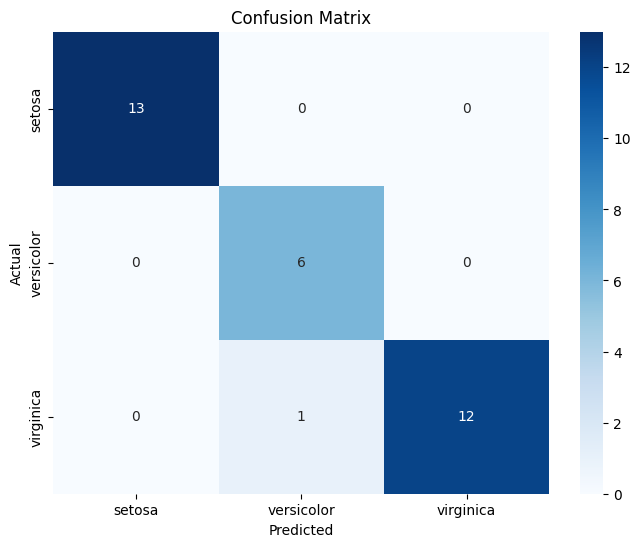

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 构建混淆矩阵 Constructing the confusion matrix
y_true = [0]*13 + [1]*6 + [2]*13
y_pred = [0]*13 + [1]*6 + [2]*12 + [1]

cm = confusion_matrix(y_true, y_pred)

# 可视化混淆矩阵 Visualizing the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
